<a href="https://colab.research.google.com/github/andr3w1699/HumanLanguageTechnologyProject/blob/main/SentimentClassificationWithRecurrent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Classification with Neural Text Representation on Amazon Reviews
# Static Embedding + RNN and its variant
In this notebook you can find the implementation of a sentiment classification task on the dataset: *Amazon Review Full Score Dataset* available at the following link: [dataset](https://drive.google.com/file/d/0Bz8a_Dbh9QhbZVhsUnRWRDhETzA/view?usp=share_link&resourcekey=0-Rp0ynafmZGZ5MflGmvwLGg
).

Specifically in this notebook it is possible to find the implementation of one of the two proposed approaches, called static embedding + RNN. In the following picture on the left branch, the proposed pipeline is showed.

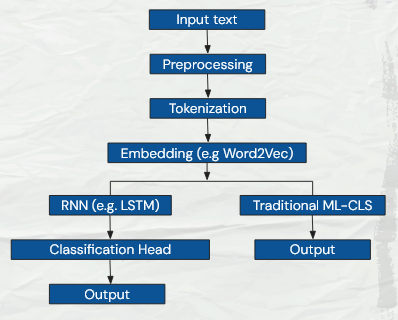

In [1]:
# install gdown used to download files from Google Drive
!pip install -q gdown

In [56]:
# import
import tarfile
import pandas as pd
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Bidirectional,LSTM, Input, Dense, Dropout, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, GRU, SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import os

# Load Dataset, Data Understanding and preprocessing

In [3]:
# Replace FILE_ID with your actual file ID
file_id = '0Bz8a_Dbh9QhbZVhsUnRWRDhETzA'
output_name = 'amazon_review_full_csv.tar.gz'

!gdown --id {file_id} -O {output_name}

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=0Bz8a_Dbh9QhbZVhsUnRWRDhETzA
From (redirected): https://drive.google.com/uc?id=0Bz8a_Dbh9QhbZVhsUnRWRDhETzA&confirm=t&uuid=0023879b-cc46-44e2-9d5d-50f3249eae65
To: /content/amazon_review_full_csv.tar.gz
100% 644M/644M [00:12<00:00, 52.1MB/s]


In [4]:
# extract the .tar.gz
with tarfile.open(output_name, "r:gz") as tar:
    tar.extractall("Dataset")

In [5]:
!ls -R Dataset

Dataset:
amazon_review_full_csv

Dataset/amazon_review_full_csv:
readme.txt  test.csv  train.csv


In [6]:
# Set options to show full text and all rows
pd.set_option('display.max_colwidth', None)

df_train = pd.read_csv(
    './Dataset/amazon_review_full_csv/train.csv',
    header=None,
    names=['label', 'title', 'text'],
    quotechar='"',
    doublequote=True,
    escapechar='\\',
    engine='python',
    encoding='utf-8',
    on_bad_lines='skip'  # Skip rows with parsing errors
)

df_train.head()

,label,title,text
0,3,more like funchuck,"Gave this to my dad for a gag gift after directing ""Nunsense,"" he got a reall kick out of it!"
1,5,Inspiring,"I hope a lot of people hear this cd. We need more strong and positive vibes like this. Great vocals, fresh tunes, cross-cultural happiness. Her blues is from the gut. The pop sounds are catchy and mature."
2,5,The best soundtrack ever to anything.,"I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny."
3,4,Chrono Cross OST,"The music of Yasunori Misuda is without question my close second below the great Nobuo Uematsu.Chrono Cross OST is a wonderful creation filled with rich orchestra and synthesized sounds. While ambiance is one of the music's major factors, yet at times it's very uplifting and vigorous. Some of my favourite tracks include; ""Scars Left by Time, The Girl who Stole the Stars, and Another World""."
4,5,Too good to be true,Probably the greatest soundtrack in history! Usually it's better to have played the game first but this is so enjoyable anyway! I worked so hard getting this soundtrack and after spending [money] to get it it was really worth every penny!! Get this OST! it's amazing! The first few tracks will have you dancing around with delight (especially Scars Left by Time)!! BUY IT NOW!!


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999746 entries, 0 to 2999745
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   label   int64 
 1   title   object
 2   text    object
dtypes: int64(1), object(2)
memory usage: 68.7+ MB


In [8]:
# Show total null values in each column
df_train.isnull().sum()

,0
label,0
title,188
text,0


In [9]:
# see the rows that contains Null values
df_train[df_train.isnull().any(axis=1)]

,label,title,text
5985,5,NaN,"I am reading this book in 7th grade advanced language arts. Most students don't like it and think that it's confusing, but i love it."
10849,2,NaN,Couldn't get the device to work with my network so it just sits there useless.Vendor exceeded delivery expectations!
21999,2,NaN,"What separates this band from Evanescence (besides geography-these guys are from Slovenia) is mainly the structural song arrangements, the inclusion of a violin, and a few industrial/progressive/gothic parts. Otherwise, you'd swear this is Evanescence's experimental follow-up album. But in the end this is Melodic Hard Rock with many catchy hooks/choruses and songs that could easily be played on the radio. The role of the violin here is just as vital as the role of a guitar, dominating throughout the record and enhancing the music. Without it, this record would probably be extremely unoriginal. Basic, yet energetic female vocals keep the flow of the music listenable. There are some brilliant musical passages like in the song ""Shut Up"" (1:46-2:14), as well as silly male verbal chants (like on ""Blah Blah"" 2:56-3:10), but overall the harmlessness and accessibility of the material is enough to satisfy the open-minded ear."
26818,3,NaN,"Upon an initial glance at one passage (immediately after downloading this volume) I find that it is not completely devoid of the Greek, as another review might lead you to believe. However, it is an abridged edition, containing less information than my hardcover 6 volume set. Overall, I expect it to be a handy quick-reference that will give some insight without too much detail."
33679,3,NaN,Although this is an interesting book to browse it has not worked well as a reference source for college studies. Searches for what I consider to be common ecological terms and concepts usually end up with no results found. Perhaps the book is not intended as a reference manual.
...,...,...,...
2877965,5,NaN,"I've been using this mouse pad for a little over a month now, and there's no other way to describe it except 'superb'. Or I guess you could insert your personal favorite superlative. 'excellent' also works nicely.Anyway, the mouse pad itself is actually just shy of being as big as my monitor (19""). So, you can have your sensitivity as low as you want and not ever. run out of room. Ever. Seriously. I personally like the control side the most - for some reason I just feel more... in control or my mouse. Compared to my generic cloth mouse pad that I've had for the past 3 computers , this thing makes it seem as though my mouse is levitating. (I'm using the razer copperhead mouse, by the way.)Oh, and the squishy wrist rest is sure to keep my wrist safe from carpal tunnel for good while. It's really quite comfortable.All jokes aside, this is definitely the best mouse pad I've ever owned. If you've never had anything but a cloth mouse pad (or no mouse pad) prepare to be amazed."
2955788,4,NaN,This book saved my sanity when my twins refused to sleep. They quickly got onto a sleep eat play routine and became happy instead of always cranky. However it doesnt work for all babies. My youngest just wasnt going for the routine. it took several months to find a smooth schedule for him. You dont have to follow this scientifically. take what works for you and find other resources as well.
2971464,2,NaN,IBD should sell single issues for the iPad to make a useable version available at a fair price!!!
2979783,2,NaN,I got on a short story kick after reading Jhumpa Lahari. This definitely is not of that calibar. Better luck next time.


In [10]:
# Check how many duplicate rows exist
df_train.duplicated().sum()

np.int64(0)

In [11]:
df_train['label'].value_counts(normalize=True) * 100

,proportion
label,
4,20.000493
5,20.000460
1,19.999860
3,19.999660
2,19.999527


distribution w.r.t. to the label values is very balanced

In [12]:
# Number of rows
print("Number of rows:", len(df_train))

# Check for null values
if df_train.isnull().values.any():
    print("There are null elements in the DataFrame.")
else:
    print("There are no null elements in the DataFrame.")

Number of rows: 2999746
There are null elements in the DataFrame.


In [13]:
df_hold_out_test = pd.read_csv(
    './Dataset/amazon_review_full_csv/test.csv',
    header=None,
    names=['label', 'title', 'text'],
    quotechar='"',
    doublequote=True,
    escapechar='\\',
    engine='python',
    encoding='utf-8',
    on_bad_lines='skip'  # Skip rows with parsing errors
)

df_hold_out_test.head()


KeyboardInterrupt: 

In [ ]:
# Number of rows
print("Number of rows:", len(df_hold_out_test))

# Check for null values
if df_hold_out_test.isnull().values.any():
    print("There are null elements in the DataFrame.")
else:
    print("There are no null elements in the DataFrame.")

In [14]:
# Keep only positive (4,5) and negative (1,2) ratings
# throw away neutral reviews with rating = 3
df_train = df_train[df_train['label'] != 3].copy()

# Map ratings to binary sentiment
df_train['sentiment'] = df_train['label'].apply(lambda x: 1 if x > 3 else 0)

In [15]:
df_train['label'].value_counts()

,count
label,
4,599964
5,599963
1,599945
2,599935


In [16]:
df_train.head(10)

,label,title,text,sentiment
1,5,Inspiring,"I hope a lot of people hear this cd. We need more strong and positive vibes like this. Great vocals, fresh tunes, cross-cultural happiness. Her blues is from the gut. The pop sounds are catchy and mature.",1
2,5,The best soundtrack ever to anything.,"I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.",1
3,4,Chrono Cross OST,"The music of Yasunori Misuda is without question my close second below the great Nobuo Uematsu.Chrono Cross OST is a wonderful creation filled with rich orchestra and synthesized sounds. While ambiance is one of the music's major factors, yet at times it's very uplifting and vigorous. Some of my favourite tracks include; ""Scars Left by Time, The Girl who Stole the Stars, and Another World"".",1
4,5,Too good to be true,Probably the greatest soundtrack in history! Usually it's better to have played the game first but this is so enjoyable anyway! I worked so hard getting this soundtrack and after spending [money] to get it it was really worth every penny!! Get this OST! it's amazing! The first few tracks will have you dancing around with delight (especially Scars Left by Time)!! BUY IT NOW!!,1
5,5,There's a reason for the price,"There's a reason this CD is so expensive, even the version that's not an import.Some of the best music ever. I could listen to every track every minute of every day. That's about all i can say.",1
6,1,Buyer beware,"This is a self-published book, and if you want to know why--read a few paragraphs! Those 5 star reviews must have been written by Ms. Haddon's family and friends--or perhaps, by herself! I can't imagine anyone reading the whole thing--I spent an evening with the book and a friend and we were in hysterics reading bits and pieces of it to one another. It is most definitely bad enough to be entered into some kind of a ""worst book"" contest. I can't believe Amazon even sells this kind of thing. Maybe I can offer them my 8th grade term paper on ""To Kill a Mockingbird""--a book I am quite sure Ms. Haddon never heard of. Anyway, unless you are in a mood to send a book to someone as a joke---stay far, far away from this one!",0
7,4,"Errors, but great story","I was a dissapointed to see errors on the back cover, but since I paid for the book I read it anyway. I have to say I love it. I couldn't put it down. I read the whole book in two hours. I say buy it. I say read it. It is sad, but it gives an interesting point of view on church today. We spend too much time looking at the faults of others. I also enjoyed beloved.Sincerly,Jaylynn R",1
8,1,The Worst!,"A complete waste of time. Typographical errors, poor grammar, and a totally pathetic plot add up to absolutely nothing. I'm embarrassed for this author and very disappointed I actually paid for this book.",0
9,1,Oh please,"I guess you have to be a romance novel lover for this one, and not a very discerning one. All others beware! It is absolute drivel. I figured I was in trouble when a typo is prominently featured on the back cover, but the first page of the book removed all doubt. Wait - maybe I'm missing the point. A quick re-read of the beginning now makes it clear. This has to be an intentional churning of over-heated prose for satiric purposes. Phew, so glad I didn't waste $10.95 after all.",0
10,1,Awful beyond belief!,"I feel I have to write to keep others from wasting their money. This book seems to have been written by a 7th grader with poor grammatical skills for her age! As another reviewer points out, there is a misspelling on the cover, and I believe there is at l

In [17]:
# create the column review which is a concatenation of title + text
df_train['review'] = df_train['title'].fillna('') + ' ' + df_train['text'].fillna('')
df_train.head(10)

,label,title,text,sentiment,review
1,5,Inspiring,"I hope a lot of people hear this cd. We need more strong and positive vibes like this. Great vocals, fresh tunes, cross-cultural happiness. Her blues is from the gut. The pop sounds are catchy and mature.",1,"Inspiring I hope a lot of people hear this cd. We need more strong and positive vibes like this. Great vocals, fresh tunes, cross-cultural happiness. Her blues is from the gut. The pop sounds are catchy and mature."
2,5,The best soundtrack ever to anything.,"I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.",1,"The best soundtrack ever to anything. I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny."
3,4,Chrono Cross OST,"The music of Yasunori Misuda is without question my close second below the great Nobuo Uematsu.Chrono Cross OST is a wonderful creation filled with rich orchestra and synthesized sounds. While ambiance is one of the music's major factors, yet at times it's very uplifting and vigorous. Some of my favourite tracks include; ""Scars Left by Time, The Girl who Stole the Stars, and Another World"".",1,"Chrono Cross OST The music of Yasunori Misuda is without question my close second below the great Nobuo Uematsu.Chrono Cross OST is a wonderful creation filled with rich orchestra and synthesized sounds. While ambiance is one of the music's major factors, yet at times it's very uplifting and vigorous. Some of my favourite tracks include; ""Scars Left by Time, The Girl who Stole the Stars, and Another World""."
4,5,Too good to be true,Probably the greatest soundtrack in history! Usually it's better to have played the game first but this is so enjoyable anyway! I worked so hard getting this soundtrack and after spending [money] to get it it was really worth every penny!! Get this OST! it's amazing! The first few tracks will have you dancing around with delight (especially Scars Left by Time)!! BUY IT NOW!!,1,Too good to be true Probably the greatest soundtrack in history! Usually it's better to have played the game first but this is so enjoyable anyway! I worked so hard getting this soundtrack and after spending [money] to get it it was really worth every penny!! Get this OST! it's amazing! The first few tracks will have you dancing around with delight (especially Scars Left by Time)!! BUY IT NOW!!
5,5,There's a reason for the price,"There's a reason this CD is so expensive, even the version that's not an import.Some of the best music ever. I could listen to every track every minute of every day. That's about all i can say.",1,"There's a reason for the price There's a reason this CD is so expensive, even the version that's not an import.Some of the best music ever. I could listen to every track every minute of every day. That's about all i can say."
6,1,Buyer beware,"This is a self-published book, and if you want to know why--read a few paragraphs! Those 5 star reviews must have been written by Ms. Haddon's family and friends--or perhaps, by herself! I can't imagine anyone reading the whole thing--I spent an evening with the book and a friend and we were in hysterics reading bits and pieces of it to one another. It is most definitely bad eno

In [19]:
# here do a MINIMAL text preprocessing
# lowercasing and remove line breaks
df_train['review'] = df_train['review'].apply(lambda text: text.lower().replace('\n', ' '))
df_train.head(10)

,label,title,text,sentiment,review
1,5,Inspiring,"I hope a lot of people hear this cd. We need more strong and positive vibes like this. Great vocals, fresh tunes, cross-cultural happiness. Her blues is from the gut. The pop sounds are catchy and mature.",1,"inspiring i hope a lot of people hear this cd. we need more strong and positive vibes like this. great vocals, fresh tunes, cross-cultural happiness. her blues is from the gut. the pop sounds are catchy and mature."
2,5,The best soundtrack ever to anything.,"I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.",1,"the best soundtrack ever to anything. i'm reading a lot of reviews saying that this is the best 'game soundtrack' and i figured that i'd write a review to disagree a bit. this in my opinino is yasunori mitsuda's ultimate masterpiece. the music is timeless and i'm been listening to it for years now and its beauty simply refuses to fade.the price tag on this is pretty staggering i must say, but if you are going to buy any cd for this much money, this is the only one that i feel would be worth every penny."
3,4,Chrono Cross OST,"The music of Yasunori Misuda is without question my close second below the great Nobuo Uematsu.Chrono Cross OST is a wonderful creation filled with rich orchestra and synthesized sounds. While ambiance is one of the music's major factors, yet at times it's very uplifting and vigorous. Some of my favourite tracks include; ""Scars Left by Time, The Girl who Stole the Stars, and Another World"".",1,"chrono cross ost the music of yasunori misuda is without question my close second below the great nobuo uematsu.chrono cross ost is a wonderful creation filled with rich orchestra and synthesized sounds. while ambiance is one of the music's major factors, yet at times it's very uplifting and vigorous. some of my favourite tracks include; ""scars left by time, the girl who stole the stars, and another world""."
4,5,Too good to be true,Probably the greatest soundtrack in history! Usually it's better to have played the game first but this is so enjoyable anyway! I worked so hard getting this soundtrack and after spending [money] to get it it was really worth every penny!! Get this OST! it's amazing! The first few tracks will have you dancing around with delight (especially Scars Left by Time)!! BUY IT NOW!!,1,too good to be true probably the greatest soundtrack in history! usually it's better to have played the game first but this is so enjoyable anyway! i worked so hard getting this soundtrack and after spending [money] to get it it was really worth every penny!! get this ost! it's amazing! the first few tracks will have you dancing around with delight (especially scars left by time)!! buy it now!!
5,5,There's a reason for the price,"There's a reason this CD is so expensive, even the version that's not an import.Some of the best music ever. I could listen to every track every minute of every day. That's about all i can say.",1,"there's a reason for the price there's a reason this cd is so expensive, even the version that's not an import.some of the best music ever. i could listen to every track every minute of every day. that's about all i can say."
6,1,Buyer beware,"This is a self-published book, and if you want to know why--read a few paragraphs! Those 5 star reviews must have been written by Ms. Haddon's family and friends--or perhaps, by herself! I can't imagine anyone reading the whole thing--I spent an evening with the book and a friend and we were in hysterics reading bits and pieces of it to one another. It is most definitely bad eno

### Subsample and Splin Train vs Internal Test set

In [20]:
# subsample 1 milion Rows
df_sample = df_train.sample(n=1_000_000, random_state=42)

In [21]:
# split into train and internal test set
X = df_sample['review']
y = df_sample['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # stratify keeps label distribution consistent
)

###Tokenization

In [22]:
# Set vocabulary size
max_words = 30000  # Only keep the 30,000 most common words

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")

# fit the tokenizer on TR set
tokenizer.fit_on_texts(X_train)

# tokenize TR set
train_sequences = tokenizer.texts_to_sequences(X_train)
# tokenize TS set
test_sequences = tokenizer.texts_to_sequences(X_test)

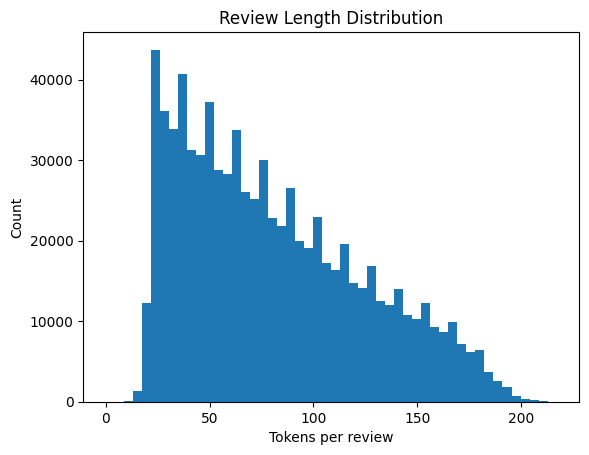

In [23]:
# analyzing review length distribution before padding
lengths = [len(seq) for seq in train_sequences]
plt.hist(lengths, bins=50)
plt.title("Review Length Distribution")
plt.xlabel("Tokens per review")
plt.ylabel("Count")
plt.show()

In [24]:
print("95th percentile length:", np.percentile(lengths, 95))

95th percentile length: 164.0


In [25]:
max_len = 164      # set max review length in tokens

# pad train seq.
train_sequences_padded = pad_sequences(train_sequences, maxlen=max_len, padding='pre', truncating='pre')
# pad test seq.
test_sequences_padded = pad_sequences(test_sequences, maxlen=max_len, padding='pre', truncating='pre')

# 1° Model: BiLTSM

In [27]:
# define the model

embedding_dim = 128

model_BiLSTM = Sequential([
    Embedding(input_dim=30000, output_dim=embedding_dim, input_length=train_sequences_padded.shape[1]),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_BiLSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [28]:
# Train the model
history = model_BiLSTM.fit(
    train_sequences_padded, y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 124s 24ms/step - accuracy: 0.8805 - loss: 0.2781 - val_accuracy: 0.9319 - val_loss: 0.1799
Epoch 2/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 132s 22ms/step - accuracy: 0.9441 - loss: 0.1514 - val_accuracy: 0.9355 - val_loss: 0.1710
Epoch 3/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 145s 23ms/step - accuracy: 0.9596 - loss: 0.1130 - val_accuracy: 0.9337 - val_loss: 0.1862
Epoch 4/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 144s 23ms/step - accuracy: 0.9710 - loss: 0.0839 - val_accuracy: 0.9315 - val_loss: 0.2029


In [30]:
# Predict probabilities
y_pred_probs = model_BiLSTM.predict(test_sequences_padded)
# Convert to binary labels
y_pred = (y_pred_probs > 0.5).astype("int32")

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)



6250/6250 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step
Accuracy: 0.935835
Precision: 0.9393591409547409
Recall: 0.9319149361421462
F1 Score: 0.935622231475025
Confusion Matrix:
 [[93914  6020]
 [ 6813 93253]]


# 2° Model: BiLSTM + CNN

In [33]:
# Build the model
model_BiLSTM_CNN = Sequential([
    Embedding(input_dim=30000, output_dim=128, input_shape=(train_sequences_padded.shape[1],)),
    Bidirectional(LSTM(64, return_sequences=True)),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_BiLSTM_CNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display model summary
model_BiLSTM_CNN.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 164, 128)       │     3,840,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 164, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 162, 64)        │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 81, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,963,521 (15.12 MB)

 Trainable params: 3,963,521 (15.12 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Train the model
history = model_BiLSTM_CNN.fit(
    train_sequences_padded, y_train,
    epochs=10,
    batch_size=512,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 83s 63ms/step - accuracy: 0.8614 - loss: 0.3108 - val_accuracy: 0.9269 - val_loss: 0.1885
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 76s 60ms/step - accuracy: 0.9417 - loss: 0.1597 - val_accuracy: 0.9328 - val_loss: 0.1754
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 88s 65ms/step - accuracy: 0.9550 - loss: 0.1275 - val_accuracy: 0.9327 - val_loss: 0.1783
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 80s 63ms/step - accuracy: 0.9650 - loss: 0.1019 - val_accuracy: 0.9307 - val_loss: 0.1953


In [40]:
# Predict probabilities
y_pred_probs = model_BiLSTM_CNN.predict(test_sequences_padded)
# Convert probabilities to binary predictions
y_pred = (y_pred_probs > 0.5).astype("int32")

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Display metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step
Accuracy: 0.9322
Precision: 0.9233
Recall: 0.9428
F1 Score: 0.9330
Confusion Matrix:
[[92101  7833]
 [ 5725 94341]]


#3° Model: GRU

In [38]:
# build model
model_GRU = Sequential([
    Embedding(input_dim=30000, output_dim=128, input_shape=(train_sequences_padded.shape[1],)),
    GRU(64),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_GRU.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_GRU.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 164, 128)       │     3,840,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,881,473 (14.81 MB)

 Trainable params: 3,881,473 (14.81 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
# Train the model
history = model_GRU.fit(
    train_sequences_padded, y_train,
    epochs=10,
    batch_size=512,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 31s 23ms/step - accuracy: 0.8436 - loss: 0.3348 - val_accuracy: 0.9255 - val_loss: 0.1927
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.9369 - loss: 0.1672 - val_accuracy: 0.9323 - val_loss: 0.1755
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 45s 26ms/step - accuracy: 0.9523 - loss: 0.1320 - val_accuracy: 0.9322 - val_loss: 0.1803
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 37s 23ms/step - accuracy: 0.9629 - loss: 0.1067 - val_accuracy: 0.9304 - val_loss: 0.1941


In [41]:
# Evaluate
# Predict probabilities
y_pred_probs = model_GRU.predict(test_sequences_padded)
# Convert probabilities to binary predictions
y_pred = (y_pred_probs > 0.5).astype("int32")

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Display metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step
Accuracy: 0.9321
Precision: 0.9316
Recall: 0.9327
F1 Score: 0.9321
Confusion Matrix:
[[93080  6854]
 [ 6734 93332]]


# 4° Model: LSTM

In [42]:
# build model
model_LSTM = Sequential([
    Embedding(input_dim=30000, output_dim=128, input_shape=(train_sequences_padded.shape[1],)),
    LSTM(64),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_LSTM.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 164, 128)       │     3,840,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,893,633 (14.85 MB)

 Trainable params: 3,893,633 (14.85 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
# Train the model
history = model_LSTM.fit(
    train_sequences_padded, y_train,
    epochs=10,
    batch_size=512,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.8589 - loss: 0.3186 - val_accuracy: 0.9271 - val_loss: 0.1885
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.9385 - loss: 0.1628 - val_accuracy: 0.9311 - val_loss: 0.1788
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 44s 27ms/step - accuracy: 0.9528 - loss: 0.1297 - val_accuracy: 0.9304 - val_loss: 0.1906
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 26ms/step - accuracy: 0.9631 - loss: 0.1047 - val_accuracy: 0.9271 - val_loss: 0.1994


In [44]:
# Evaluate
# Predict probabilities
y_pred_probs = model_LSTM.predict(test_sequences_padded)
# Convert probabilities to binary predictions
y_pred = (y_pred_probs > 0.5).astype("int32")

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Display metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step
Accuracy: 0.9307
Precision: 0.9370
Recall: 0.9235
F1 Score: 0.9302
Confusion Matrix:
[[93723  6211]
 [ 7653 92413]]


# 5° Model: Vanilla/Simple RNN

In [47]:
# build the model
model_Simple_RNN = Sequential([
    Embedding(input_dim=30000, output_dim=128, input_shape=(train_sequences_padded.shape[1],)),
    SimpleRNN(128),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_Simple_RNN.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_Simple_RNN.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 164, 128)       │     3,840,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,881,217 (14.81 MB)

 Trainable params: 3,881,217 (14.81 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
# Train
history = model_Simple_RNN.fit(
    train_sequences_padded, y_train,
    epochs=10,
    batch_size=512,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 43s 31ms/step - accuracy: 0.8168 - loss: 0.3754 - val_accuracy: 0.8974 - val_loss: 0.2592
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 28ms/step - accuracy: 0.8573 - loss: 0.3319 - val_accuracy: 0.8935 - val_loss: 0.2882
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 35s 28ms/step - accuracy: 0.8972 - loss: 0.2578 - val_accuracy: 0.9039 - val_loss: 0.2436
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - accuracy: 0.9171 - loss: 0.2163 - val_accuracy: 0.8203 - val_loss: 0.4974
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - accuracy: 0.8844 - loss: 0.2869 - val_accuracy: 0.8220 - val_loss: 0.4347


In [49]:
# Evaluate
# Predict probabilities
y_pred_probs = model_Simple_RNN.predict(test_sequences_padded)
# Convert probabilities to binary predictions
y_pred = (y_pred_probs > 0.5).astype("int32")

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Display metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step
Accuracy: 0.9050
Precision: 0.9030
Recall: 0.9077
F1 Score: 0.9054
Confusion Matrix:
[[90180  9754]
 [ 9237 90829]]


# 6° Model: Stacked BiLSTM

In [52]:
# Build the model
model_stacked_BiLSTM = Sequential([
    Embedding(input_dim=30000  , output_dim=128, input_length=train_sequences_padded.shape[1]),
    Bidirectional(LSTM(64, return_sequences=True)), # return_sequences is necessary when stacking LSTM layers
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_stacked_BiLSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [53]:
# Train the model
history = model_stacked_BiLSTM.fit(
    train_sequences_padded, y_train,
    epochs=10,
    batch_size=512,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 118s 91ms/step - accuracy: 0.8591 - loss: 0.3167 - val_accuracy: 0.9276 - val_loss: 0.1867
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 142s 91ms/step - accuracy: 0.9386 - loss: 0.1645 - val_accuracy: 0.9318 - val_loss: 0.1796
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 143s 92ms/step - accuracy: 0.9537 - loss: 0.1296 - val_accuracy: 0.9301 - val_loss: 0.1831
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 143s 93ms/step - accuracy: 0.9644 - loss: 0.1030 - val_accuracy: 0.9280 - val_loss: 0.2150


In [54]:
# Evaluate
# Predict probabilities
y_pred_probs = model_stacked_BiLSTM.predict(test_sequences_padded)
# Convert probabilities to binary predictions
y_pred = (y_pred_probs > 0.5).astype("int32")

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Display metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 64s 10ms/step
Accuracy: 0.9315
Precision: 0.9287
Recall: 0.9348
F1 Score: 0.9318
Confusion Matrix:
[[92754  7180]
 [ 6522 93544]]


# Glove

In [57]:
glove_path = "glove.6B.zip"

if not os.path.isfile(glove_path):
    !wget -c http://nlp.stanford.edu/data/glove.6B.zip
else:
    print("GloVe file already exists. Skipping download.")

--2025-05-10 18:04:31--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-05-10 18:04:31--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-05-10 18:04:32--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [58]:
if not os.path.isfile("glove.6B.300d.txt"):
    !unzip -q glove.6B.zip glove.6B.300d.txt
    print("Unzipped glove.6B.300d.txt")
else:
    print("glove.6B.300d.txt already exists. Skipping unzip.")

Unzipped glove.6B.300d.txt


In [59]:
# Load Glove Embeddings
embedding_index = {}
with open('glove.6B.300d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs
print(f'Loaded {len(embedding_index)} word vectors.')

Loaded 400000 word vectors.


In [60]:
embedding_dim = 300
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, idx in tokenizer.word_index.items():
    if idx < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
        else:
            # Random init for words not found in GloVe
            embedding_matrix[idx] = np.random.normal(size=(embedding_dim,))

## GLOVE + BiLSTM

In [63]:
model_Glove_BiLSTM = Sequential([
    Embedding(
        input_dim=30000,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_shape=(train_sequences_padded.shape[1],),
        trainable=True  # freeze or True to fine-tune
    ),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_Glove_BiLSTM.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model_Glove_BiLSTM.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (None, 164, 300)       │     9,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 128)            │       186,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,187,009 (35.05 MB)

 Trainable params: 9,187,009 (35.05 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
history = model_Glove_BiLSTM.fit(
    train_sequences_padded, y_train,
    epochs=10,
    batch_size=512,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 104s 81ms/step - accuracy: 0.8496 - loss: 0.3354 - val_accuracy: 0.9227 - val_loss: 0.1978
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 142s 80ms/step - accuracy: 0.9324 - loss: 0.1785 - val_accuracy: 0.9318 - val_loss: 0.1802
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 143s 81ms/step - accuracy: 0.9480 - loss: 0.1437 - val_accuracy: 0.9305 - val_loss: 0.1853
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 139s 79ms/step - accuracy: 0.9590 - loss: 0.1162 - val_accuracy: 0.9325 - val_loss: 0.1871


In [65]:
# Evaluate
# Predict probabilities
y_pred_probs = model_Glove_BiLSTM.predict(test_sequences_padded)
# Convert probabilities to binary predictions
y_pred = (y_pred_probs > 0.5).astype("int32")

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Display metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step
Accuracy: 0.9317
Precision: 0.9416
Recall: 0.9205
F1 Score: 0.9309
Confusion Matrix:
[[94220  5714]
 [ 7953 92113]]


# FasText

In [66]:
if not os.path.isfile("wiki-news-300d-1M.vec.zip"):
    !wget -c https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
else:
    print("FastText zip file already exists. Skipping download.")

if not os.path.isfile("wiki-news-300d-1M.vec"):
    !unzip -q wiki-news-300d-1M.vec.zip
    print("Unzipped FastText vectors.")
else:
    print("FastText .vec file already extracted. Skipping unzip.")

--2025-05-10 18:21:43--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.15, 108.157.254.121, 108.157.254.124, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M   121MB/s    in 8.3s    

2025-05-10 18:21:51 (78.0 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]

Unzipped FastText vectors.


In [68]:
embedding_index = {}
with open('wiki-news-300d-1M.vec', encoding='utf8', errors='ignore') as f:
    next(f)  # skip header line: “1000000 300”
    for line in f:
        values = line.rstrip().split(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

In [69]:
embedding_dim = 300
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, idx in tokenizer.word_index.items():
    if idx < max_words:
        vector = embedding_index.get(word)
        if vector is not None:
            embedding_matrix[idx] = vector
        else:
            # you can use random init or zeros
            embedding_matrix[idx] = np.random.normal(size=(embedding_dim,))

## FasText + BiLSTM

In [70]:
model_FT_BiLSTM = Sequential([
    Input(shape=(max_len,)),
    Embedding(
        input_dim=max_words,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=train_sequences_padded.shape[1],
        trainable=True  # or True to fine-tune
    ),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_FT_BiLSTM.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model_FT_BiLSTM.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ (None, 164, 300)       │     9,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 128)            │       186,880 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,187,009 (35.05 MB)

 Trainable params: 9,187,009 (35.05 MB)

 Non-trainable params: 0 (0.00 B)

In [71]:
history = model_FT_BiLSTM.fit(
    train_sequences_padded, y_train,
    epochs=10,
    batch_size=512,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 108s 82ms/step - accuracy: 0.8409 - loss: 0.3481 - val_accuracy: 0.9241 - val_loss: 0.1947
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 100s 80ms/step - accuracy: 0.9346 - loss: 0.1754 - val_accuracy: 0.9321 - val_loss: 0.1776
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 145s 82ms/step - accuracy: 0.9504 - loss: 0.1373 - val_accuracy: 0.9326 - val_loss: 0.1845
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 140s 81ms/step - accuracy: 0.9619 - loss: 0.1105 - val_accuracy: 0.9303 - val_loss: 0.1923


In [73]:
# Evaluate
# Predict probabilities
y_pred_probs = model_FT_BiLSTM.predict(test_sequences_padded)
# Convert probabilities to binary predictions
y_pred = (y_pred_probs > 0.5).astype("int32")

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Display metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step
Accuracy: 0.9308
Precision: 0.9273
Recall: 0.9350
F1 Score: 0.9311
Confusion Matrix:
[[92602  7332]
 [ 6508 93558]]
